In [67]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import transformers
import os
import re
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A) Preprocessing

##  1. Custom Dataset Class
#### Implement a map-style dataset from .csv files; needed because data files train_titles.csv and test_titles.csv cannot be directly passed to the dataloader

In [68]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __getitem__(self, idx):
        sentence = self.data.loc[idx].text
        ids = self.tokenizer(self.tokenizer.bos_token + ' ' + sentence + ' ' + self.tokenizer.eos_token,  padding = 'max_length', truncation = True, max_length = self.maxLen)['input_ids']

        label = self.data.loc[idx].food
        return torch.tensor(ids),label
 
    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())

## 2. GPT2 Tokenizer using Huggingface

In [69]:
from torch.utils.data import DataLoader
maxLen = 128
batchSize = 512
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
numAdded = tokenizer.add_special_tokens({'pad_token': '[PAD]', 'bos_token':'[BOS]','eos_token':'[EOS]','unk_token':'[UNK]'})
print(f'Number of added tokens = {numAdded}')
padId,bosId,eosId,unkId  = (tokenizer.encode(tokenizer.pad_token)[0], tokenizer.encode(tokenizer.bos_token)[0], tokenizer.encode(tokenizer.eos_token)[0], tokenizer.encode(tokenizer.unk_token)[0]) 
print(f'TokenIds = {padId, bosId, eosId,unkId}')
vocabSize = len(tokenizer)

Number of added tokens = 4
TokenIds = (50257, 50258, 50259, 50260)


## 3. Create Custom Dataloaders from  Text Dataset

In [70]:
trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train data points  = {trainData.__len__()}')
#trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData, batch_size=1, shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train data points  = 67972
Number of test data points = 22716


#### Print an example data point (tokens/tokenIds) and label

In [71]:
data = next(iter(trainLoader))
print(f"Encoded Text = {data[0][0]}")
print(f"Encoded Label = {data[1][0]}")
print(f"Check - Decoded tokens from encoded ids: \n{tokenizer.decode(data[0][0])}")

Encoded Text = tensor([50258,  1312,    12,   261,  7093,    25, 49957,   539, 14296,   220,
        50259, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257,

## 4. Convert categorical labels (recipe names) to numerical labels (0,1,2,....101)

In [72]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[1]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}

# B) LSTM + Feedforward Model

In [73]:
class lstmClassifier(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses, padId, maxLen):
        super(lstmClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC0 = nn.Linear(maxLen,1)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()
        self.padId = padId

    def forward(self, x_):
        x = self.word_embeddings(x_) # input dimensions are (batch size, sqeuenquence length) - output dimensions are (batch size, sequence length, feature size)
        x[x_ == self.padId,:] = 0 # set rows, where each row is of dimension equal to hidden_size, corresponding to pad id = 0
        (x,_) = self.LSTM(x)     # dimension x = (batchSize, number of words, hidden_size)    
        x = torch.transpose(x,1,2)
        x = self.FC0.forward(x)
        x = torch.squeeze(x,axis = -1)
        x = self.drop1(x)               
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

In [74]:
import numpy
from transformers import GPT2Config
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 128
dModel = 128
numClasses = 101
model = lstmClassifier(vocab_size=vocabSize, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses, padId = padId, maxLen = maxLen
                )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
lossVals = []
model = model.to(device)
print(model)

lstmClassifier(
  (word_embeddings): Embedding(50261, 128)
  (LSTM): LSTM(128, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (FC0): Linear(in_features=128, out_features=1, bias=True)
  (FC1): Linear(in_features=128, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=256, out_features=101, bias=True)
  (Relu): ReLU()
)


## 1. Train LSTM + Feedforward Model

In [75]:
for epoch in range(3):  # loop over the dataset multiple times
    for data in trainLoader:
        inputs,labels_ = data
        labels = torch.tensor([lblMap[x] for x in labels_])
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().cpu().clone().numpy())
        optimizer.step()
    if epoch%1 == 0:
        print(f"Epoch = {epoch}. Loss = {loss}")
print('Finished Training')

Epoch = 0. Loss = 1.02780020236969
Epoch = 1. Loss = 0.9217524528503418
Epoch = 2. Loss = 0.7743805050849915
Finished Training


## 2. Test LSTM + Feedforward Model

In [76]:
model.eval() # again no gradients needed - so set mode.eval()
correct_pred = 0
numTst = 0
for data in testLoader:
    inputs, labels_ = data
    numTst = numTst + inputs.shape[0]
    labels = []
    labels.append([lblMap[x] for x in labels_])
    labels = torch.tensor(labels[0])
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred += 1

accuracy = 100 * float(correct_pred)/ numTst
print(f"Classification Accuracy = {accuracy:.3f}%")

Classification Accuracy = 83.862%


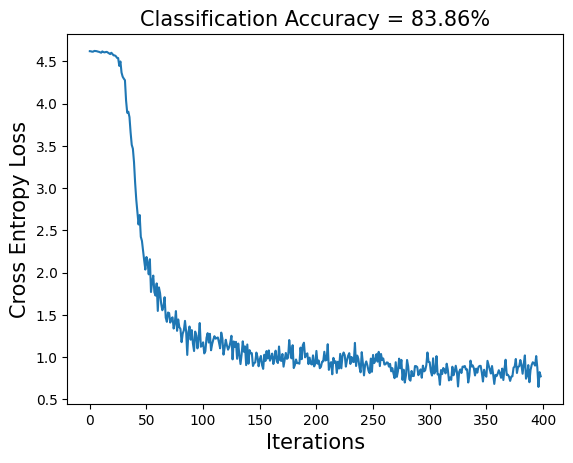

In [77]:
import numpy as np
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
#path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dModel,accuracy, maxLen,hidden_size)
#plt.savefig(path+'.pdf')